# **Importing Libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing ,csv file Input/Output
import keras
import math
from IPython import display
import random as python_random
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2 as cv
import tqdm
import io
import os,glob
import ipywidgets as widgets
#from PIL import image
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model
from keras.models import Model
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from scikitplot.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from keras import datasets,layers,Sequential
from zipfile import ZipFile
from sklearn import preprocessing
from keras.layers import BatchNormalization
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

np.random.seed(40)
tf.random.set_seed(40)

# **Installing Scikit Library**

In [ ]:
!pip install scikit-plot

# **Loading DataSet**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

 92% 145M/158M [00:02<00:00, 81.5MB/s]
100% 158M/158M [00:02<00:00, 64.2MB/s]


In [ ]:
file = "/content/covid19-image-dataset.zip"
with ZipFile(file,'r') as zip:
  zip.extractall()
  print('Done')


Done


In [ ]:
x = []
y = []
labels = ['Covid', 'Normal', 'Viral Pneumonia']
image_size = 224
dataset_path = '/content/Covid19-dataset/train'

for label in labels:
    folderPath = os.path.join(dataset_path, label)
    for img_file in os.listdir(folderPath):
        img_path = os.path.join(folderPath, img_file)
        img_read = cv.imread(img_path)
        img_read = cv.resize(img_read, (image_size, image_size))
        x.append(img_read)
        y.append(label)

x = np.array(x)
y = np.array(y)

In [ ]:
x,y = shuffle(x,y,random_state = 101 )

In [ ]:
print(f"Shape of X: {x.shape}")
print(f"Shape of Y: {y.shape}")

Shape of X: (251, 224, 224, 3)
Shape of Y: (251,)


In [ ]:
print(f"Shape of one example: {x[0].shape}")

Shape of one example: (224, 224, 3)


# **Displaying Some Pictures**

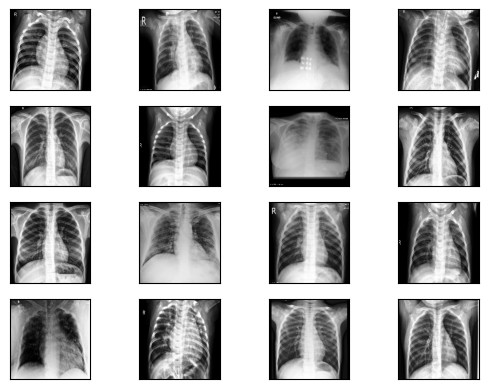

In [ ]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x[i],cmap=plt.cm.binary)

# **Train Test Split**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state=42)

In [ ]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (200, 224, 224, 3)
Shape of x_test: (51, 224, 224, 3)
Shape of y_train: (200,)
Shape of y_test: (51,)


# **Label Encoding**

In [ ]:
#for train data
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
#for test data
y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# **Using VGG16**

In [ ]:
from keras.applications import vgg16

In [ ]:
r , c = 224 , 224
vgg = vgg16.VGG16(weights = 'imagenet', include_top = False,input_shape=(r,c,3))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers: #no need to train pre-trained layers
  layer.trainable = False


In [ ]:
def vgg_model(bottom_model,claases):
  t_models = bottom_model.output
  t_models = GlobalAveragePooling2D()(t_models)
  t_models = Dense(1024,activation = 'relu')(t_models)
  t_models = Dense(512,activation = 'relu')(t_models)
  t_models = Dense(64,activation = 'relu')(t_models)
  t_models = Dense(32,activation = 'relu')(t_models)
  t_models = Dense(3,activation = 'softmax')(t_models)
  return t_models

# **Building Model**

In [ ]:
model_head = vgg_model(vgg,2)
model = Model(inputs = vgg.input,outputs = model_head)

# **Neural Network Structure**

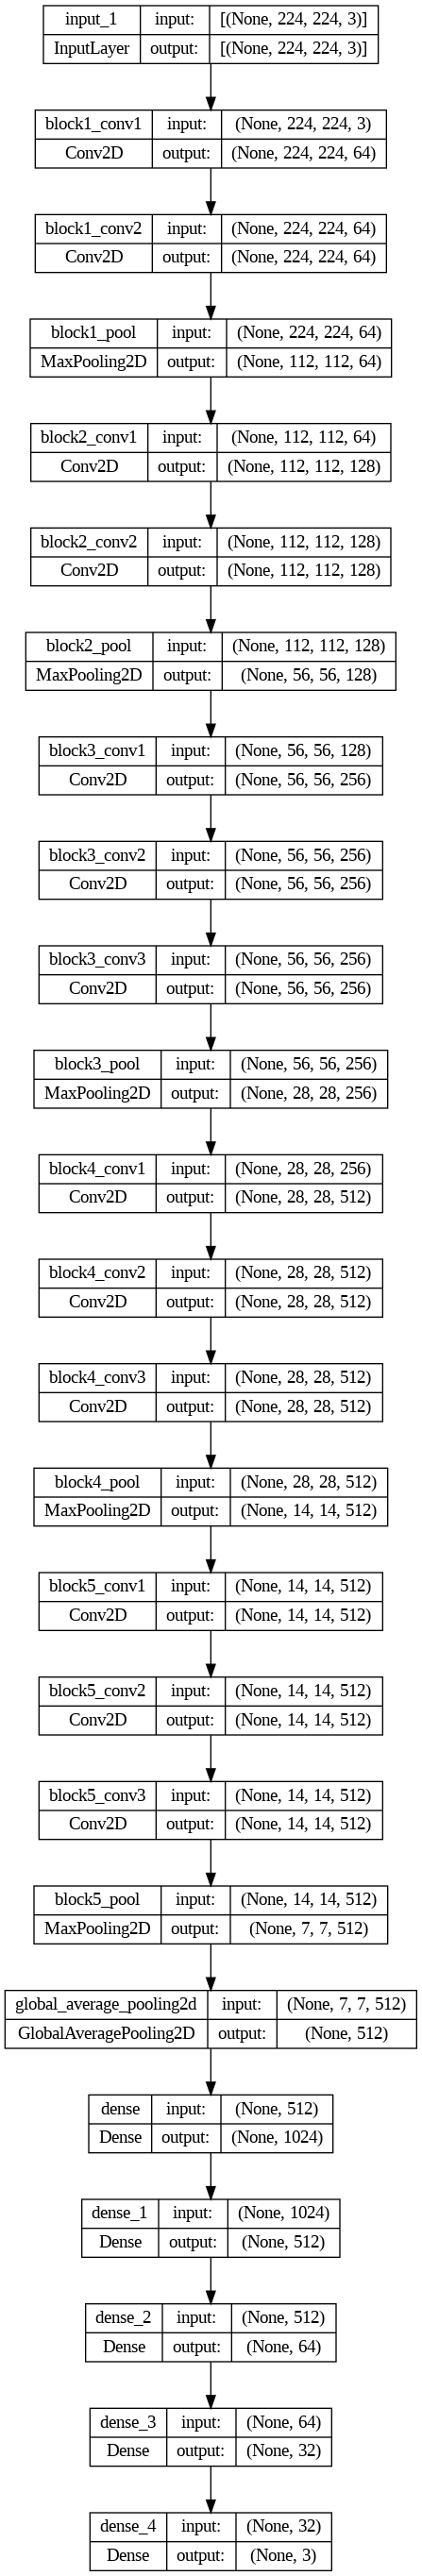

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Showing the shape of input and output**

In [ ]:
# Print the shapes of model input and output
print("Input shape:", model.input_shape)
print("Output shape:", model.output_shape)

Input shape: (None, 224, 224, 3)
Output shape: (None, 3)


In [ ]:
# Print the shapes of x_train and y_train
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (200, 224, 224, 3)
y_train shape: (200, 3)


In [ ]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),metrics = ['accuracy'])

# **Fitting The model**

In [ ]:
model.fit(x_train,y_train,epochs=20,validation_data=(x_test,y_test),initial_epoch=0)

Epoch 1/20
7/7 [==============================] - 163s 23s/step - loss: 0.7461 - accuracy: 0.7150 - val_loss: 0.5796 - val_accuracy: 0.7255
Epoch 2/20
7/7 [==============================] - 158s 23s/step - loss: 0.2692 - accuracy: 0.9100 - val_loss: 0.3422 - val_accuracy: 0.8824
Epoch 3/20
7/7 [==============================] - 165s 24s/step - loss: 0.1628 - accuracy: 0.9400 - val_loss: 0.3137 - val_accuracy: 0.9020
Epoch 4/20
7/7 [==============================] - 159s 23s/step - loss: 0.0942 - accuracy: 0.9750 - val_loss: 0.2597 - val_accuracy: 0.9020
Epoch 5/20
7/7 [==============================] - 146s 21s/step - loss: 0.0639 - accuracy: 0.9850 - val_loss: 0.2636 - val_accuracy: 0.9020
Epoch 6/20
7/7 [==============================] - 157s 23s/step - loss: 0.0400 - accuracy: 0.9900 - val_loss: 0.2517 - val_accuracy: 0.9216
Epoch 7/20
7/7 [==============================] - 163s 24s/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.2591 - val_accuracy: 0.9020
Epoch 8/20
7/7 [====

# **Model Accuracy is:**

# **Seeing the Accuracy in Percentage**

In [ ]:
score = model.evaluate(x_test,y_test)
print(f"Accuracy of the model to detect Covid 19 is: {score[1]*100:0.2f}%")

2/2 [==============================] - 29s 11s/step - loss: 0.2680 - accuracy: 0.9216
Accuracy of the model to detect Covid 19 is: 92.16%


# **Making a Prediction**

In [ ]:
import random

In [ ]:
x.shape

(251, 224, 224, 3)

In [ ]:
y.shape

(251,)

In [ ]:
index = random.randrange(0,250,1)
print(f"The Random Index is: {index}")

The Random Index is: 141


Image at the index Number: 141: 


Text(0.5, 0, 'Covid')

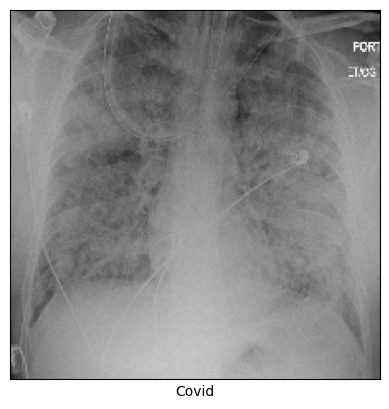

In [ ]:
print(f"Image at the index Number: {index}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index],cmap = plt.cm.binary)
plt.xlabel(y[index])

In [ ]:
x[index].shape

(224, 224, 3)

In [ ]:
x_new = x[index]
x_new =tf.expand_dims(x_new,axis = 0)

In [ ]:
pred = model.predict(x_new)

1/1 [==============================] - 1s 767ms/step


In [ ]:
pred


array([[9.9974984e-01, 7.3905389e-06, 2.4279293e-04]], dtype=float32)

In [ ]:
val = np.argmax(pred)

In [ ]:
print(f"The Prediction made is: {labels[val]}")

The Prediction made is: Covid


# **Making Another Prediction**

In [ ]:
index2 = random.randrange(0,250,1)
print(f"The Random Index is: {index2}")


The Random Index is: 246


Image at the index Number: 246: 


Text(0.5, 0, 'Covid')

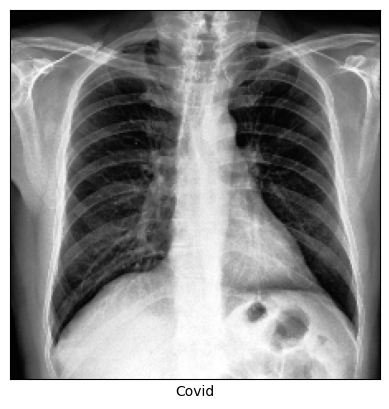

In [ ]:
print(f"Image at the index Number: {index2}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index2],cmap = plt.cm.binary)
plt.xlabel(y[index2])


In [ ]:
x[index2].shape

(224, 224, 3)

In [ ]:
x_new2 = x[index2]
x_new2 =tf.expand_dims(x_new2,axis = 0)

In [ ]:
pred2 = model.predict(x_new2)
val2 = np.argmax(pred2)

1/1 [==============================] - 1s 517ms/step


In [ ]:
print(f"The Prediction made is: {labels[val2]}")

The Prediction made is: Covid


In [ ]:
index2 = random.randrange(0,250,1)
print(f"The Random Index is: {index2}")

The Random Index is: 14


Image at the index Number: 14: 


Text(0.5, 0, 'Normal')

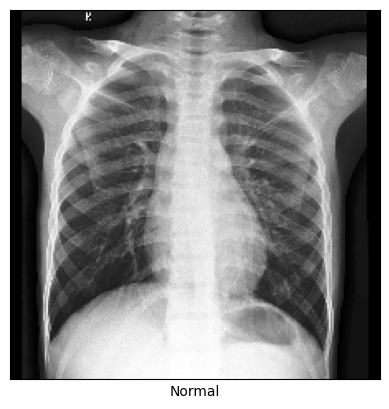

In [ ]:
print(f"Image at the index Number: {index2}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index2],cmap = plt.cm.binary)
plt.xlabel(y[index2])
